# ACML Lab 2: Convolutional Autoencoders
Sree Kotala i6206796
Michal Kalbarczyk i6223513

In [1]:
#Importing the necessary packages.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset from a numpy file
data = np.load("cifar-10.npz")
filenames = ['x_train', 'y_train', 'x_test', 'y_test']
nps = []

for filename in filenames:
    nps.append(data[filename])
    
train_images, train_labels, test_images, test_labels = nps

## Reconstruction

In [3]:
#Prepping transformation(s)

datagen_norm = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
)

# Combine the data -> done to overcome the silly 50k/10k split
X = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

# Normalize the data
trans_norm = datagen_norm.flow(X, batch_size=len(X))
X = trans_norm.next()


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

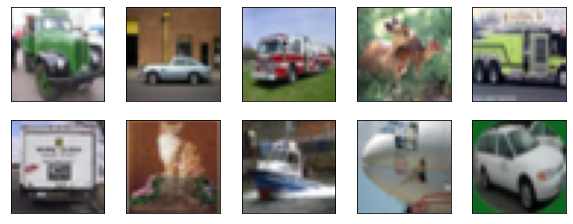

In [4]:
# Plot the images as a sanity check

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

In [6]:
# Build the model
class Autoencoder(Model):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding="same", strides=1, input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2), padding="same", strides=1),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.MaxPooling2D((2, 2), padding="same", strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding="same", strides=1)
        ])

        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(size=(2,2),padding="same", strides=1),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.UpSampling2D(size=(2,2),padding="same", strides=1),
            layers.Conv2D(3, (3, 3), activation='relu', padding="same", strides=1)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Build the model
class Autoencoder_variant(Model):

    def __init__(self):
        super(Autoencoder_variant, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding="same", strides=1, input_shape=(32, 32, 3)),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu', padding="same", strides=1)
        ])

        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(3, (3, 3), activation='relu', padding="same", strides=1)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# Compile the model
autoencoder = Autoencoder_variant()
autoencoder.compile(optimizer='adam',
                    loss=losses.MeanSquaredError(),
                    metrics=['mse', 'accuracy'])

In [11]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64,
                          validation_split = (0.1/0.9),
                          validation_data=(X_test, X_test))

Epoch 1/10
750/750 [==============================] - 38s 50ms/step - loss: 0.0342 - mse: 0.0342 - accuracy: 0.5745 - val_loss: 0.0070 - val_mse: 0.0070 - val_accuracy: 0.7174
Epoch 2/10
750/750 [==============================] - 34s 46ms/step - loss: 0.0059 - mse: 0.0059 - accuracy: 0.7404 - val_loss: 0.0052 - val_mse: 0.0052 - val_accuracy: 0.7601
Epoch 3/10
750/750 [==============================] - 35s 47ms/step - loss: 0.0048 - mse: 0.0048 - accuracy: 0.7714 - val_loss: 0.0046 - val_mse: 0.0046 - val_accuracy: 0.7858
Epoch 4/10
750/750 [==============================] - 34s 45ms/step - loss: 0.0044 - mse: 0.0044 - accuracy: 0.7841 - val_loss: 0.0043 - val_mse: 0.0043 - val_accuracy: 0.7910
Epoch 5/10
750/750 [==============================] - 34s 45ms/step - loss: 0.0042 - mse: 0.0042 - accuracy: 0.7931 - val_loss: 0.0041 - val_mse: 0.0041 - val_accuracy: 0.7803
Epoch 6/10
750/750 [==============================] - 33s 44ms/step - loss: 0.0040 - mse: 0.0040 - accuracy: 0.7993 - va

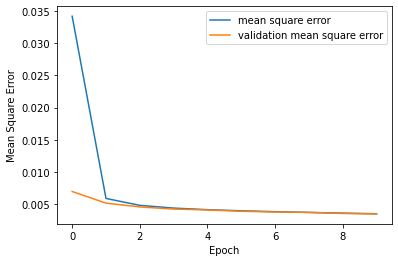

In [12]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [75]:
# Make the predictions
predictions = autoencoder.predict(X_test[:])

# Evaluate the predictions 
autoencoder.evaluate(predictions, X_test)

375/375 [==============================] - 3s 8ms/step - loss: 0.0043 - mse: 0.0043 - accuracy: 0.7418


[0.00433950824663043, 0.00433950824663043, 0.741844892501831]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


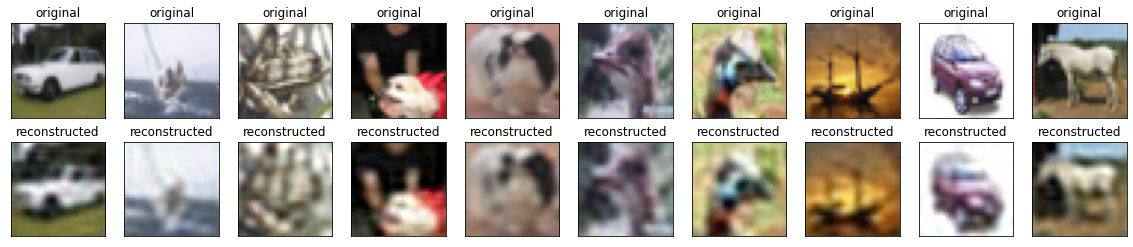

In [14]:
# Check the predictions
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

375/375 [==============================] - 1s 4ms/step


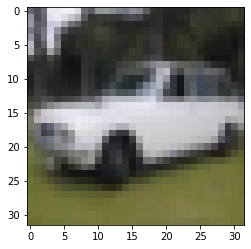

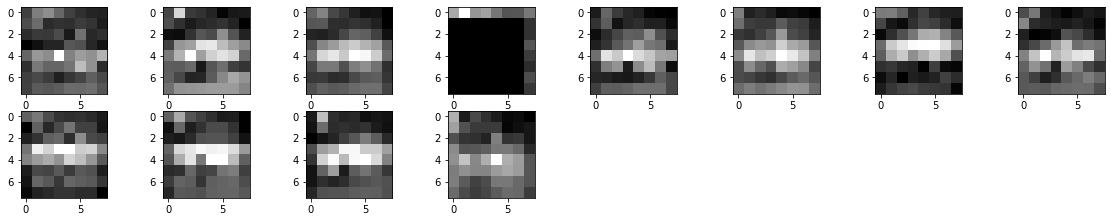

In [72]:
model = autoencoder.encoder
model = Model(inputs=model.inputs , outputs=model.layers[3].output)

predictions = model.predict(X_test[:])
features = predictions[0]

plt.imshow(X_test[0] , cmap='gray')

fig = plt.figure(figsize=(20,15))
for i in range(1, features.shape[2]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[:, :, i-1] , cmap='gray')
    
plt.show()

In [48]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 8)        0         
 ooling2D)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 12)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
Total params: 2,844
Trainable params: 2,844
Non-traina

375/375 [==============================] - 2s 4ms/step
fmap shape: (32, 32, 8)

i: 1
	shape:(8, 8, 16)

i: 2
	shape:(8, 8, 16)

i: 3
	shape:(8, 8, 16)

i: 4
	shape:(8, 8, 16)

i: 5
	shape:(8, 8, 16)

i: 6
	shape:(8, 8, 16)

i: 7
	shape:(8, 8, 16)

i: 8
	shape:(8, 8, 16)

i: 9
	shape:(8, 8, 16)


IndexError: index 8 is out of bounds for axis 2 with size 8

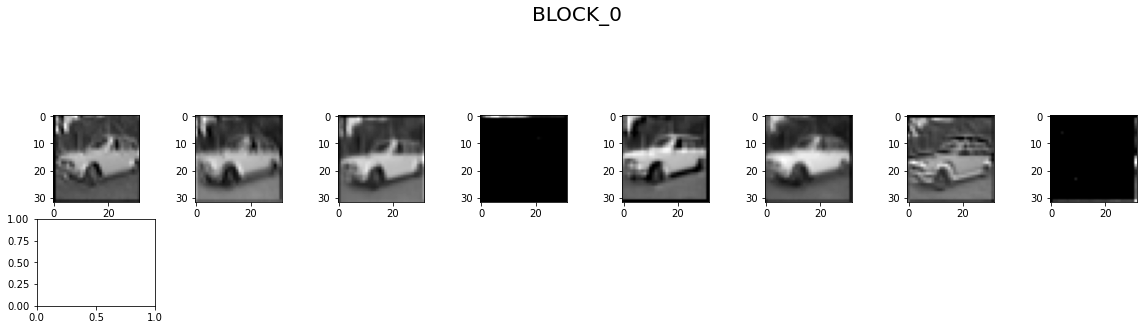

In [63]:
model = Model(inputs=model.inputs , outputs=model.output)

blocks = [0, 2, 4]
outputs = [autoencoder.encoder.layers[i].output for i in blocks]

model2 = Model(inputs = model.inputs, outputs = outputs)

predictions = model2.predict(X_test[:])
feature_map = predictions[0]

for i, fmap in zip(blocks, feature_map):
    print(f"fmap shape: {fmap.shape}")
    fig = plt.figure(figsize=(20,15))
    
    #https://stackoverflow.com/a/12444777
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1, features.shape[2]+1):
        print(f"\ni: {i}\n\tshape:{features.shape}")
        plt.subplot(8,8,i)
        plt.imshow(fmap[:,:,i-1] , cmap='gray')
    
plt.show()

#### TODO

Change the metric that we are outputing from accuracy to the mean squared error as the assignment description requires us to report the mean squared error, simple as changing the code into 'metrics=\[metrics.MeanSquaredError()\]' instead of the accuracy being the metric we report.

Add code that calculates the test error output (mean square error so we can compare to the outputs of train and validation)
   - https://github.com/up42/image-similarity-measures/blob/master/image_similarity_measures/quality_metrics.py
      - Could use this website to define an MSE metric that compares an input set of images, change the RMSE to just MSE and cite the source.

Latent space size calculation (maybe find a method that does this or automate it to be used with various models)

Try alternate architectures: e.g. fewer intermediate layers, change num channels, filter sizes, stride, and padding configs.
   - What is the impact of those on the reconstruction error after training.
   - Is there a link between the size of the latent space representation and the error (from your tests)


## Colorization

Adapt the previous 'best' model to recolorize images from greyscale to RGB

In [13]:
# Prepare additional transformations required for colorization using an autoencoder
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

datagen_gray = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=to_grayscale
)

In [14]:
#Creating a copy of the train array to convert to greyscale
X_train_gray = X_train.copy()

In [15]:
# TAKES A MINUTE ON MY COMPUTER

# Apply the transformation
trans_train_gray = datagen_gray.flow(X_train_gray, batch_size=len(X_train),shuffle=False)
trans_test_gray = datagen_gray.flow(X_test, batch_size=len(X_test),shuffle=False)

# Store the transformed GRAY images
X_train_gray = trans_train_gray.next()
X_test_gray = trans_test_gray.next()

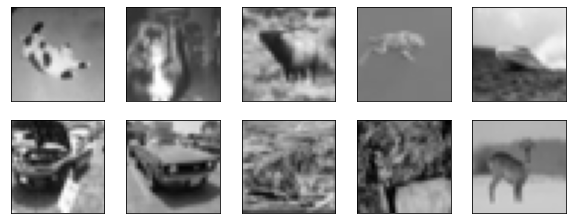

In [16]:
# Plot the images just to be sure the transformations worked

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_gray[i])
plt.show()

In [17]:
# Train the colorization model
history = autoencoder.fit(X_train_gray, X_train, epochs=20, batch_size=64,
                          validation_split = (0.1/0.9),
                          validation_data=(X_test, X_test))

Epoch 1/20
667/667 [==============================] - 27s 41ms/step - loss: 0.0095 - mse: 0.0095 - accuracy: 0.4352 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.4103
Epoch 2/20
667/667 [==============================] - 27s 41ms/step - loss: 0.0092 - mse: 0.0092 - accuracy: 0.4495 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.4289
Epoch 3/20
667/667 [==============================] - 28s 42ms/step - loss: 0.0092 - mse: 0.0092 - accuracy: 0.4528 - val_loss: 0.0091 - val_mse: 0.0091 - val_accuracy: 0.4573
Epoch 4/20
667/667 [==============================] - 28s 41ms/step - loss: 0.0091 - mse: 0.0091 - accuracy: 0.4538 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.3697
Epoch 5/20
667/667 [==============================] - 27s 41ms/step - loss: 0.0090 - mse: 0.0090 - accuracy: 0.4556 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.4859
Epoch 6/20
667/667 [==============================] - 28s 41ms/step - loss: 0.0090 - mse: 0.0090 - accuracy: 0.4572 - va

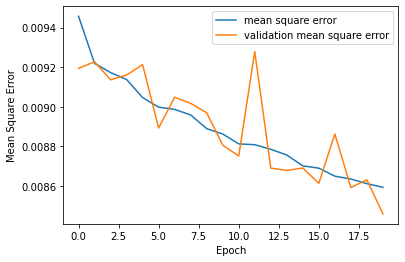

In [18]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [19]:
# Make the predictions
predictions = autoencoder.predict(X_test_gray[:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


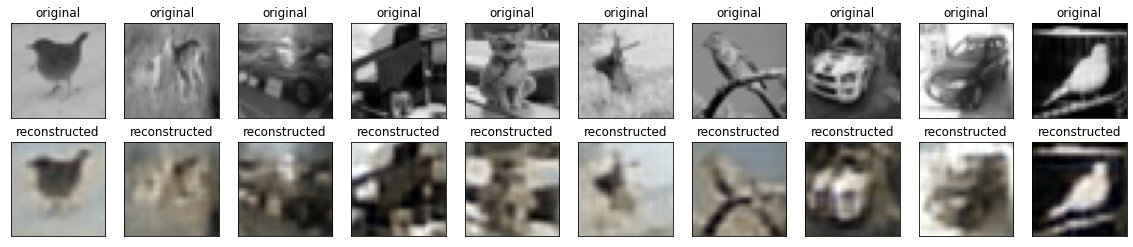

In [20]:
# Check the predictions 
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_gray[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## TODO

Create error function for this part that looks at the difference between the reconstructed image and the output of the reconstruction from the previous portion as then the blurring is taken into consideration adn we see how well our reconstruction performs. We could also look at the error as the diff between output and original test output but then we will see even worse results.

Report on the results and the shortcomings of the approach, What aspects could be improved (of arch, hyper params, optimization) to get a better fit?

Kurt mentioned some hint about looking at predicting the chrominance of the image rather than the colour of the image itself, and then using the Chrominance to recreate the original colour image from the greyscale. This involves the following.
   - Converting the images from RGB space to YCbCr space:
   - Y = Intensity, Cb = Chrominance blue, Cr = Chrominance red
   - (MY IDEA FOR NOW: using knowledge from the SIP course from last period)
        - train different autoencoders, or one that splits into two then combine
            - first one tries to predict Cb from greyscale
            - second tries to predict Cr from greyscale
        - Determine Y from the input, pass through the image into the Cb and Cr autoencoder, then combine YCbCr outputs together. Afterwhich we convert this back into RGB space and present this as the output.